## Transmitter Code

In [150]:
# Import all needed modules

import numpy as np
import scipy

from matplotlib import pyplot as plt
import random

from py import ldpc # LDPC from Jossy

In [151]:
# Define OFDM parameters:

symbol_length = 4096
cyclic_length = 512

In [152]:
# Find LDPC Information

c = ldpc.code(standard = '802.16', rate = '1/2', z=42, ptype='A')

print("LDPC PARAMETERS\n===============")

print("Info length: ", c.K)
print("Codeword length: ", c.N)

print(c.Nmsg,  "number of messages")
print(c.vdeg,  "variable node degrees")
print(c.cdeg,  "constraint node degrees")
print(c.intrlv,  "code interleaver")
print(c.standard,  "IEEE standard")
print(c.rate, "(code rate string)")
print(c.z,  "z parameter of IEEE standard")
print(c.ptype,  "code type for 802.16 rate 2/3 and 3/4")
print(c.proto,  "proto (protograph")

LDPC PARAMETERS
Info length:  504
Codeword length:  1008
3192 number of messages
[3 3 3 ... 2 2 2] variable node degrees
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6

In [153]:
# OPEN FILE TO TRANSMIT

with open('max_test_in.txt', 'r') as file:
    data = file.read().replace('\n', '')

binary_data = ''.join(format(ord(x), 'b').zfill(8) for x in data)

print(len(binary_data))
print(binary_data[0:128])

384888
01000001011000110110001101101111011100100110010001101001011011100110011100100000011101000110111100100000011000010110110001101100


773766
(386883,)


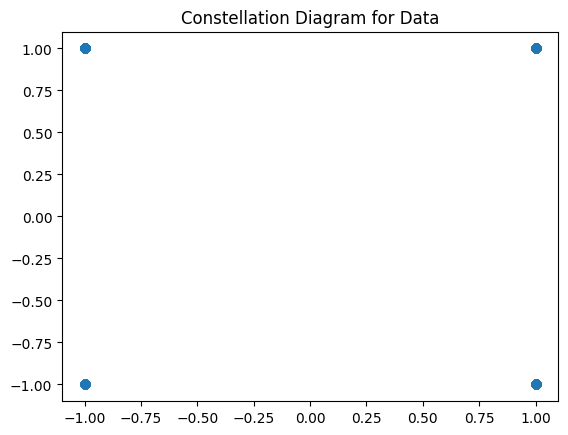

In [154]:
# LDPC ENCODING

binary_data += "0" * (c.K - (len(binary_data) % c.K))

to_ldpc = [binary_data[i:i+c.K] for i in range(0, len(binary_data), c.K)]

coded_binary_data = ''

for i in to_ldpc:
    assert len(i) == c.K

    ldpc_out = c.encode([int(i[k]) for k in range(0, len(i))]) # Needs to convert i to a list of binary numbers

    ldpc_out = ldpc_out.astype('str')

    coded_binary_data += ''.join(ldpc_out)

# coded_binary_data = binary_data # Disable ('undo') LDPC Coding

# PAD WITH 0s to match OFDM symbols

split_length = symbol_length - 2 # (symbol_length - 2) as need 511 constellation 'stars' per symbol, and each 'star' represents 2 bits.

# for i in range(split_length - (len(binary_data) % split_length)): 
#     binary_data += "0"

ofdm_padding_length = split_length - (len(coded_binary_data) % split_length)

coded_binary_data += "0" * ofdm_padding_length

assert len(coded_binary_data) % split_length == 0.0

print(len(coded_binary_data))

# ENCODE WITH GRAY CODE

to_encode = [coded_binary_data[i:i+2] for i in range(0, len(coded_binary_data), 2)] # Split into list of two characters elements

gray_code = 1j * np.arange(len(to_encode)) # 'empty' array

for index, i in enumerate(to_encode):
    if i == "00":
        gray_code[index] = 1 + 1j
    elif i == "01":
        gray_code[index] = -1 + 1j
    elif i == "11":
        gray_code[index] = -1 - 1j
    elif i == "10":
        gray_code[index] = 1 - 1j
    else:
        print(i)
        raise Exception("Gray code mapping error")

plt.scatter(gray_code[0:500].real, gray_code[0:500].imag)
print(gray_code.shape)
plt.title("Constellation Diagram for Data")
plt.show()

# gray_code is one list of all the gray code points

In [155]:
symbols = np.split(np.array(gray_code), len(gray_code) / (split_length / 2))

# ENFORCE CONJUGATE SYMMETRY:

for index, x in enumerate(symbols):
    conj = np.conjugate(x)[::-1]
    symbols[index] = np.concatenate((x, conj), axis=None) # Add reflected conjugate symmetry

    symbols[index] = np.insert(symbols[index], 0, 0)
    symbols[index] = np.insert(symbols[index], int(symbol_length / 2), 0)

# Inverse DFT

info = np.fft.ifft(symbols)

for i in info[15]:
    assert i.imag == 0 # Check is now real

# ADD CYCLIC PREFIXES

to_transmit = np.zeros(shape = (len(info), symbol_length + cyclic_length))

for index, x in enumerate(info):
    cyclic_prefix = x[-cyclic_length:]
    new_x = np.concatenate((cyclic_prefix, x), axis = None)
    to_transmit[index] = new_x

print(to_transmit.shape) # Should be (319 - or alternate length, 1056)

to_transmit = np.concatenate(to_transmit, axis = 0)

print(to_transmit.shape)

(189, 4608)
(870912,)


/var/folders/10/m2d64f1s1kx01s59h9vnf84w0000gn/T/ipykernel_13801/1326024085.py:26: ComplexWarning: Casting complex values to real discards the imaginary part
  to_transmit[index] = new_x


## Channel Simulation

In [156]:
# CHANNEL FILTER

channel_response = np.loadtxt('../weekend_files/channel.csv', delimiter = ",", dtype = "float")

to_decode = np.convolve(channel_response, to_transmit)

to_decode = to_decode[:-1 * len(channel_response) + 1]

# NOISE

for index, i in enumerate(to_decode):
    to_decode[index] = i + random.gauss(0.0, 0.005)

np.savetxt("max_test_out.csv", to_decode, delimiter = ",")


## Decoder

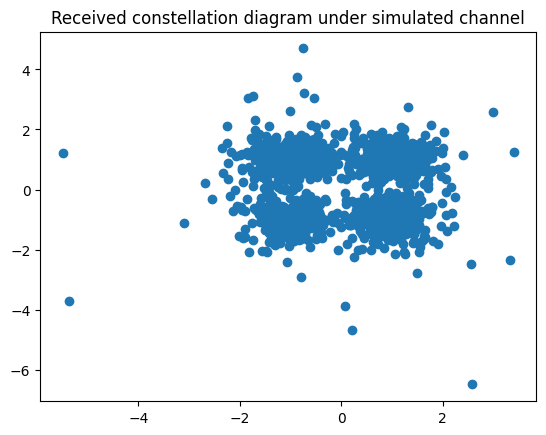

In [157]:
decoded_symbols = np.split(to_decode, len(to_decode) / (symbol_length + cyclic_length))

# Remove Cyclic Prefix

for index, i in enumerate(decoded_symbols):
    decoded_symbols[index] = i[cyclic_length:]

# DFT each symbol:

symbols_freq = np.zeros((len(decoded_symbols), symbol_length)).astype(complex) # 'empty' array

for index, i in enumerate(decoded_symbols):
    symbols_freq[index] = np.fft.fft(i)

assert symbols_freq.shape[1] == symbol_length

channel_response = np.pad(channel_response, (0, symbol_length - len(channel_response)))
channel_freq = np.fft.fft(channel_response)

# Divide by DFT of Channel Response:

recieved_freq = symbols_freq / channel_freq

constellations = recieved_freq[0][1:2048]

for index, i in enumerate(recieved_freq[1:]):
    constellations = np.vstack((constellations, i[1:2048]))

plt.scatter(constellations[10].real, constellations[10].imag)
plt.title("Received constellation diagram under simulated channel")
plt.show()


In [158]:
decoded_binary = []

# Do Inverse Gray Code:

for symbol in constellations:
    for i in symbol:
        if np.real(i) >= 0 and np.imag(i) >= 0:
            decoded_binary.append("00")
        elif np.real(i) <= 0 and np.imag(i) >= 0:
            decoded_binary.append("01")
        elif np.real(i) <= 0 and np.imag(i) <= 0:
            decoded_binary.append("11")
        elif np.real(i) >= 0 and np.imag(i) <= 0:
            decoded_binary.append("10")
        else:
            raise Exception("Gray Code Decoding Error")

decoded_binary = ''.join(decoded_binary)

In [159]:
# Remove OFDM Padding:

# TODO find OFDM Padding length automatically

# assert decoded_binary[-ofdm_padding_length:] == ("0" * ofdm_padding_length) # No idea why this doesn't work...

decoded_binary_no_padding = decoded_binary[:-ofdm_padding_length]

# LDPC DECODING

# Split into c.N lengths

to_ldpc_decoder = np.array([decoded_binary_no_padding[i:i+c.N] for i in range(0, len(decoded_binary_no_padding), c.N)])

for i in to_ldpc_decoder:
    assert len(i) == c.N

# Decode each section

binary_ldpc_out = ''

for i in to_ldpc_decoder[0:]:

    convert_to_list = np.array([int(i[k]) for k in range(0, len(i))])
    convert_to_list = 0.5 - convert_to_list # ldpc decoder needs values around 0, not around 0.5

    ldpc_out, iter = c.decode(convert_to_list) # Needs to convert i to a list of binary numbers

    ldpc_out = ldpc_out[0 : c.K] # NO IDEA WHAT ldpc_out CONTAINS AFTER c.K ?? Why is it the same size as the codewords?

    binary_ldpc_out += ''.join(['0' if j > 0 else '1' for j in ldpc_out])


In [160]:
# CONVERT BINARY TO ASCII

# binary_ldpc_out = decoded_binary # Disable LDPC

success = 0
fail = 0

print(len(binary_ldpc_out))
print(len(binary_data))

for index, i in enumerate(binary_ldpc_out[:385056]):
    if i == binary_data[index]:
        success += 1
    else:
        fail += 1

print(success / (success + fail))

# Split into 7 bit sections:

decoded_text = ''

ascii = [int(binary_ldpc_out[i:i+8], 2) for i in range(0, len(binary_ldpc_out), 8)]
decoded_text_list = [chr(i) for i in ascii]

decoded_text = ''.join([chr(i) for i in ascii])


f = open("max_test_out.txt", "w")
f.write(decoded_text)
f.close()

g = open("max_test_in.txt", "w")
g.write(data)
g.close()

385056
385056
0.9817299301919721
